# QROM

Quantum read-only memory.

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `QROM`
Bloq to load `data[l]` in the target register when the selection stores an index `l`.

In the case of multidimensional `data[p,q,r,...]` we use multiple named
selection registers to index and load the data named selection0, selection1, ...

When the input data elements contain consecutive entries of identical data elements to
load, the QROM also implements the "variable-spaced" QROM optimization described in Ref [2].

#### Parameters
 - `data`: List of numpy ndarrays specifying the data to load. If the length of this list is greater than one then we use the same selection indices to load each dataset (for example, to load alt and keep data for state preparation). Each data set is required to have the same shape and to be of integer type.
 - `selection_bitsizes`: The number of bits used to represent each selection register corresponding to the size of each dimension of the array. Should be the same length as the shape of each of the datasets.
 - `target_bitsizes`: The number of bits used to represent the data signature. This can be deduced from the maximum element of each of the datasets. Should be of length len(data), i.e. the number of datasets.
 - `num_controls`: The number of control signature. 

#### References
 - [Encoding Electronic Spectra in Quantum Circuits with Linear T Complexity](https://arxiv.org/abs/1805.03662).     Babbush et. al. (2018). Figure 1.
 - [Compilation of Fault-Tolerant Quantum Heuristics for Combinatorial Optimization](https://arxiv.org/abs/2007.07391).     Babbush et. al. (2020). Figure 3.


In [2]:
from qualtran.bloqs.data_loading.qrom import QROM

### Example Instances

In [3]:
data = np.arange(5)
qrom_small = QROM([data], selection_bitsizes=(3,), target_bitsizes=(3,))

In [4]:
data1 = np.arange(5)
data2 = np.arange(5) + 1
qrom_multi_data = QROM([data1, data2], selection_bitsizes=(3,), target_bitsizes=(3, 4))

In [5]:
data1 = np.arange(9).reshape((3, 3))
data2 = (np.arange(9) + 1).reshape((3, 3))
qrom_multi_dim = QROM([data1, data2], selection_bitsizes=(2, 2), target_bitsizes=(8, 8))

#### Graphical Signature

In [6]:
from qualtran.drawing import show_bloqs
show_bloqs([qrom_small, qrom_multi_data, qrom_multi_dim],
           ['`qrom_small`', '`qrom_multi_data`', '`qrom_multi_dim`'])

### Call Graph

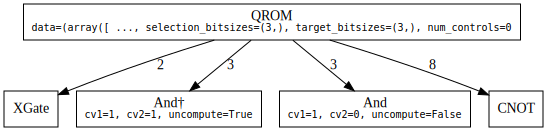

#### Counts totals:
 - `And(cv1=1, cv2=0, uncompute=False)`: 3
 - `And(cv1=1, cv2=1, uncompute=True)`: 3
 - `CNOT()`: 8
 - `XGate()`: 2

In [7]:
from qualtran.resource_counting.generalizers import ignore_split_join
qrom_small_g, qrom_small_sigma = qrom_small.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(qrom_small_g)
show_counts_sigma(qrom_small_sigma)